# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


## Loading the test image and preprocessing

In [6]:
def prepare_image(image_path):
    image_path = "/home/tantael/bmptest2.bmp"

    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    return transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [7]:
def prdict_om_image(input_image_pytorch):
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    return outputs[("disp", 0)]

## Plotting

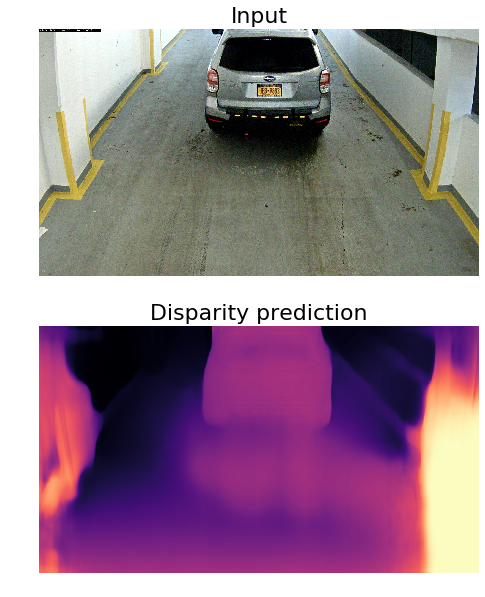

In [8]:

disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

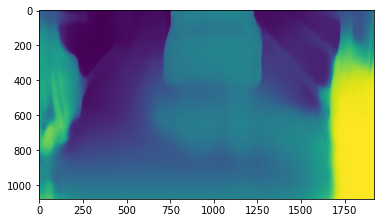

In [9]:
plt.imshow(disp_resized_np)

In [12]:
disp_resized_np.min()

0.09122025

In [11]:
from glob import glob
from pathlib import Path
import shutil

In [15]:
px = 1591587789255
px2 = 1591587776758

In [16]:
files = glob("/home/tantael/repositories/cvc/tests/test_source/murray/alg001-1591587777000/entry1/*") + glob("/home/tantael/repositories/cvc/tests/test_source/murray/alg001-1591587777000/exit1/*")

In [17]:
for file in files:
    p = Path(file)
    direcory = p.parent.name
    if px > int(p.stem) and px2 < int(p.stem):
        print(p.stem)
        shutil.copy2(file, f"./data/{direcory}/{p.stem}.jpg")

1591587784458
1591587778158
1591587782358
1591587783258
1591587778262
1591587777558
1591587779358
1591587782558
1591587777458
1591587779258
1591587787158
1591587778458
1591587781258
1591587788359
1591587779858
1591587785158
1591587783358
1591587785058
1591587785358
1591587780458
1591587782758
1591587780558
1591587779758
1591587780158
1591587781758
1591587778858
1591587781158
1591587789159
1591587782458
1591587780058
1591587787858
1591587786158
1591587787958
1591587788559
1591587777662
1591587786058
1591587777858
1591587784158
1591587779058
1591587783758
1591587781658
1591587777158
1591587787058
1591587778358
1591587784558
1591587782258
1591587778758
1591587786758
1591587785458
1591587780258
1591587779958
1591587777358
1591587787458
1591587785858
1591587782958
1591587781458
1591587780958
1591587784958
1591587780758
1591587788859
1591587788159
1591587783458
1591587782662
1591587784758
1591587780358
1591587786358
1591587781358
1591587784658
1591587783658
1591587778658
1591587777758
159158